In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2023-12-14 12:21:27,047: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [12]:
import random
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

exp = []
measurements = 128
#shots = np.arange(10, 2000, 100)
shots = [2 ** i for i in range(7, 12)]
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 4
for n in range(3, 7):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.4) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J,
                                                   f'J = {J} CosineFit n = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            ramseyBatch.curve_fit(use_fft=True)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)


ibmqfactory.load_account:WARNING:2023-09-07 15:00:21,357: Credentials are already in use. The existing account in the session will be replaced.


5
5
5


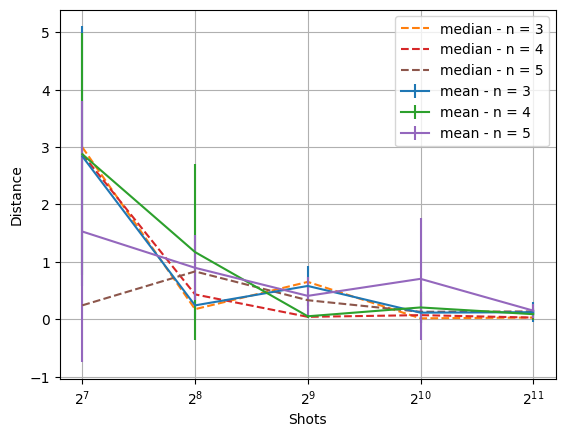

In [13]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
    plt.title("shots divided between 128 measurements")
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [14]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(7, 10)]
shots = [2 ** i for i in range(7, 12)]
#shots = [500]
repetitions = 20
for n in measurements:  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(4)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(
                    RamseyExperiment(4, t, s // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            ramseyBatch.curve_fit(use_fft=True)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)



QiskitError: 'No counts for experiment "0"'

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-',
                 label=f'mean - measurement points = {str(measurements[i])}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(measurements[i])}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points and fixed number of shots

In [4]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

n = 5
exp = []
measurements = [2 ** i for i in range(4, 9)]
shots = 5
repetitions = 20
shot_list = {}
median_dist_for_shots = []
mean_dist_for_shots = []
std_dist_for_shots = []
for n in measurements:  #qubits

    rep_list = []
    for rep in range(repetitions):
        J = [random.gauss(1, 0.4) for _ in range(n)]
        delay_list = []
        delay = np.linspace(0, 8 * np.pi, n)
        for t in delay:
            delay_list.append(
                RamseyExperiment(4, t, shots, J, "0"))
        ramseyBatch = RamseyBatch(delay_list)
        ramseyBatch.curve_fit(use_fft=True)
        rep_list.append(ramseyBatch)
    median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
    mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
    std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

shot_list["mean"] = mean_dist_for_shots
shot_list["std"] = std_dist_for_shots
shot_list["median"] = median_dist_for_shots

exp.append(shot_list)



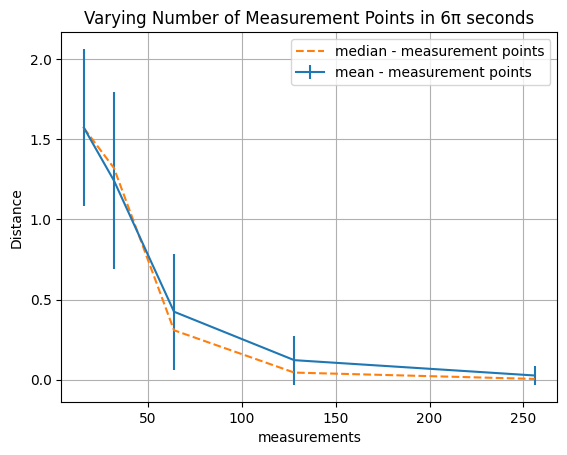

In [7]:
plt.title("Varying Number of Measurement Points in 6π seconds")
plt.grid()
plt.ylabel('Distance')
plt.xlabel('measurements')
#plt.ylim(0, 0.1)
dist = shot_list
plt.errorbar(measurements, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - measurement points')
plt.plot(measurements, dist["median"], linestyle='--', label=f'median - measurement points')

#plt.xscale('log', base=2)
plt.legend()

In [51]:
from tqdm.notebook import tqdm

n = 5
#total_time = np.arange(10, 10, 1)
#resolution = np.arange(5,10,1)
total_time = np.arange(10, 30, 1)
resolution = np.arange(2, 22, 1)
#J = [random.gauss(10, 3) for _ in range(n)]

rep = 50
shots = 500

dist = [[0] * len(resolution) for _ in range(len(total_time))]
for T in tqdm(range(len(total_time)), desc="total_time"):
    for r in (range(len(resolution))):
        J = [random.gauss(10, 3) for _ in range(n)]
        m = int(resolution[r] * total_time[T])
        delay = np.linspace(0, total_time[T], m)
        rep_list = []
        for _ in range(rep):
            delay_list = []
            for t in delay:
                delay_list.append(
                    RamseyExperiment(n, t, shots, J, "0", manual=True))
            ramseyBatch = RamseyBatch(delay_list)
            ramseyBatch.no_fit_double(use_fft=True)
            rep_list.append(ramseyBatch)
        dist[T][r] = (np.median([rep_list[i].dist for i in range(len(rep_list))]))



total_time:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'Distance')

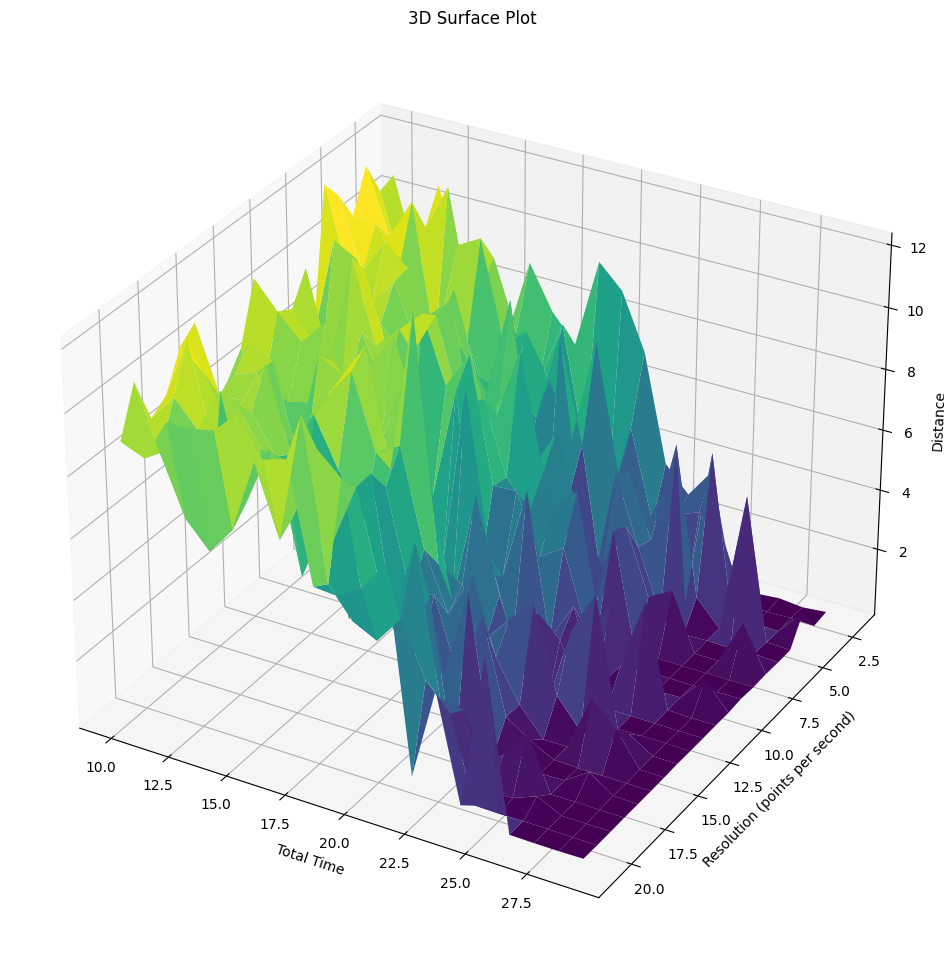

In [52]:
fig = plt.figure(figsize=(18, 12))
ax2 = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.array(total_time), np.array(resolution))
Z = np.array(dist)
ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.invert_yaxis()
ax2.set_title("3D Surface Plot")
ax2.set_xlabel("Total Time")
ax2.set_ylabel("Resolution (points per second)")
ax2.set_zlabel("Distance")


In [106]:
print(Z)

[[6.45174412e+00 6.16094397e+00 8.59393844e+00 5.79656391e+00
  5.87917946e+00 1.98587857e+00 7.48177484e+00 3.98765867e+00
  7.68757966e+00 9.18997964e-01 6.01144643e-03 6.42811018e-03
  1.30386628e+00 4.61651438e-03 5.16952578e-02 5.86846053e-03
  5.71014922e-03 8.23371335e-02 2.77023110e-01 4.16606010e-03]
 [9.25627007e+00 6.02505255e+00 1.00160252e+01 7.44101542e+00
  7.17814497e+00 1.99521066e+00 6.46723331e+00 2.20370892e+00
  3.35732560e+00 5.85688744e+00 5.08417565e+00 7.68513830e-02
  3.64595909e+00 5.91681600e-03 1.23809328e+00 3.80545680e-01
  4.21354333e-03 1.41238009e+00 8.01655304e-02 4.15986079e-03]
 [7.93909201e+00 6.76136653e+00 5.36057141e+00 5.49027623e+00
  4.19342023e+00 6.07245677e+00 4.03309024e+00 3.34180290e+00
  6.66164010e-03 1.88304128e+00 1.19477959e+00 6.69981990e-01
  4.76512176e-01 8.08021127e-01 8.30677318e-01 5.56950024e-03
  5.47573400e-03 5.01455569e-03 4.07671343e-03 2.71635429e-02]
 [6.54473696e+00 4.38763182e+00 7.95600327e+00 8.03334470e+00
  3.3

In [61]:
from scipy.optimize import curve_fit
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 15


def func(t, js):
    n = len(js)
    result = 2 * n
    for i in range(n):
        result += 4 * np.cos(4 * js[i] * t)
    for i in range(n):
        result += 2 * np.cos(4 * (js[i] + js[(i + 1) % n]) * t)
    return result / (2 ** (3))


J = [random.gauss(1, 0.4) for _ in range(n)]
shots = 50
#J = [1.1601234879309363, 1.3921915375578446, 1.1009852114016079, 1.226780187699479, 0.6196640849592935]
print("J = ", J)
delay_list = []
manual_run = []
exp = []
measurements = 50
delay = np.linspace(0, 6 * np.pi, measurements)
for t in delay:
    delay_list.append(RamseyExperiment(n, t, shots, J, "0"))
    #manual_run.append(RamseyExperiment(n, t, shots, J, "0",manual=True))
ramseyBatch1 = RamseyBatch(delay_list)
ramseyBatch2 = RamseyBatch(delay_list)

ramseyBatch1.no_fit_double(use_fft=True)
ramseyBatch2.no_fit(use_fft=True)
J_fit = ramseyBatch1.J_fit
J_fit_grad = ramseyBatch2.J_fit
print("no_fit_double: " + str(J_fit) + " dist:" + str(ramseyBatch1.dist))
print("no_fit: " + str(J_fit_grad) + " dist:" + str(ramseyBatch2.dist))
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
#plt.title(f'J = {J}')
#plt.plot(delay, ramseyBatch1.Z, label='Simulation')

plt.plot(delay, [func(t, J) for t in delay], label='theory')

plt.plot(delay, [func(t, J_fit) for t in delay], label='double fft')
plt.plot(delay, [func(t, J_fit_grad) for t in delay], label='fft')

plt.xlim(0, 2 * np.pi)
plt.legend()

ibmqfactory.load_account:WARNING:2023-12-14 15:55:03,271: Credentials are already in use. The existing account in the session will be replaced.


J =  [0.8968625240107876, 0.7590311072309311, 1.36752947640498, 1.3520503567637134, 1.5677768347535623, 1.3589924435066902, 1.1964838183028799, 0.8961855749806773, 0.5119998953713607, 1.4118326463732902, 0.8610997900533754, 1.7442983084935768, 0.7930533366238393, 1.1276023209345016, 0.47217694987236203]


MemoryError: Unable to allocate 80.0 GiB for an array with shape (5, 32768, 32768) and data type complex128

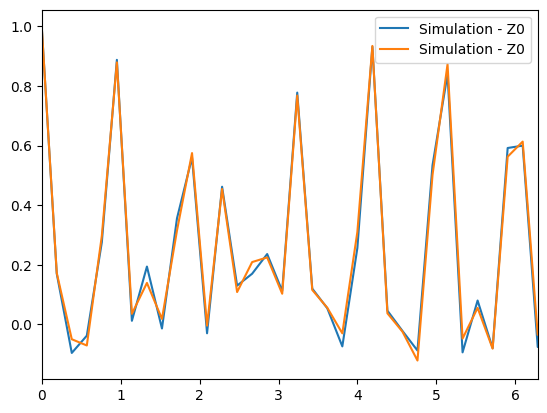

In [117]:
# def func2(t, js):
#     n = len(js)
#     result = 2
#     result += 2 * np.cos(4 * js[0] * t)
#     result += 2 * np.cos(4 * js[3] * t)
#     result += 2 * np.cos(4 * (js[0] + js[3]) * t)
#
#     return result / (2 ** (n - (n - 3)))

plt.plot(delay, ramseyBatch1.get_zi(0), label='Simulation - Z0')
plt.plot(delay, ramseyBatch2.get_zi(0), label='Simulation - Z0')

#plt.plot(delay, [func2(t, J) for t in delay], label='theory')
plt.xlim(0, 2 * np.pi)

plt.legend()

In [127]:
ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

ibmqfactory.load_account:WARNING:2023-09-06 11:55:53,573: Credentials are already in use. The existing account in the session will be replaced.


Frequency: 0.5039906531243352, Magnitude: 71.53148238059939
Frequency: 0.954929658551372, Magnitude: 28.651992129719996
Frequency: 0.6366197723675814, Magnitude: 24.040270658982536
Frequency: 1.1406104254919167, Magnitude: 21.110702506591906
Frequency: 1.0079813062486704, Magnitude: 20.8260554209308


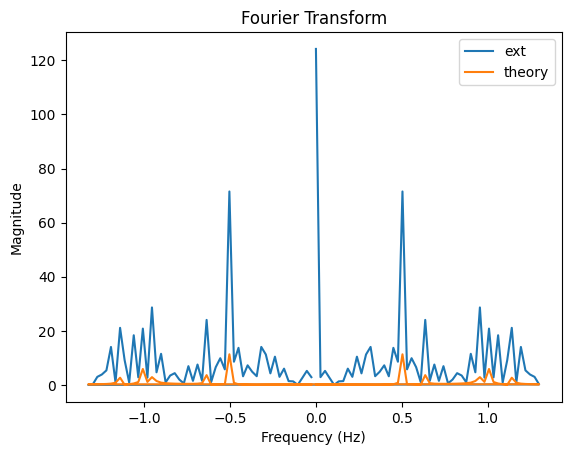

In [15]:
from scipy.signal import find_peaks
% matplotlib inline
w_ = 6 * 2 * np.pi


def fo(w, js):
    n = len(js)
    result = 0
    for i in range(n):
        #result += (np.sqrt(2/np.pi) * np.sin(10 * np.pi * (4 * js[i] + w))) / (4 * js[i] + w)

        result += 2 * (np.sqrt(2 / np.pi) * np.sin(w_ * np.pi * (2 * js[i] / np.pi + w))) / (
                    w_ * (2 * js[i] / np.pi + w))
        result += 2 * (np.sqrt(2 / np.pi) * np.sin(w_ * np.pi * (2 * js[i] / np.pi - w))) / (
                    w_ * (2 * js[i] / np.pi - w))

        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n]) / np.pi + w))) / (
                    w_ * (np.sqrt(2 / np.pi) * (2 * (js[i] + js[(i + 1) % n]) / np.pi + w)))
        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n]) / np.pi - w))) / (
                    w_ * (np.sqrt(2 / np.pi) * (2 * (js[i] + js[(i + 1) % n]) / np.pi - w)))

    #result += (3 * np.sqrt(2/np.pi) * np.sin(10 * np.pi * w)) / w
    #result = result/ (2 ** (n - (n - 3)))
    return 2 * np.pi * result / (8)


extended = ramseyBatch1.Z[::-1]
extended = extended + ramseyBatch1.Z
fft_output_ext = np.fft.fft(extended)
fft_output = np.fft.fft(ramseyBatch1.Z)

# Compute the corresponding frequencies
sample_rate = measurements / (6 * np.pi)  # Sampling rate of your data (change if known)
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.Z), 1 / sample_rate)
frequencies = np.fft.fftfreq(len(ramseyBatch1.Z), 1 / sample_rate)

plt.plot(frequencies_ext, np.abs(fft_output_ext), label="ext")
#plt.plot(frequencies, np.abs(fft_output), label= "org")


positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]

# Choose the n highest peaks
n_highest_peaks = sorted_peak_indices[:n]  # Choose a value for n

# Print the x (frequency) values of the n highest peaks
for peak_index in n_highest_peaks:
    val = frequencies_ext[positive_indices][peaks[peak_index]]
    print(
        f"Frequency: {frequencies_ext[positive_indices][peaks[peak_index]]}, Magnitude: {peak_magnitudes[peak_index]}")
    #plt.axvline(x=val, color='green', linestyle='--', label=f'x={val}')

plt.plot(frequencies_ext, np.abs([fo(t, J) for t in frequencies_ext]), label='theory')

#for val in J:
#    plt.axvline(x=val/(0.5*np.pi), color='red', linestyle='--', label=f'x={val}')


plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
#plt.xlim(0, 2)
#plt.ylim(0,10)
plt.legend()
plt.show()

## Signle qubit FFT ##


Frequency: 0.625, Magnitude: 14.599975702186999
Frequency: 1.25, Magnitude: 9.554348876943724


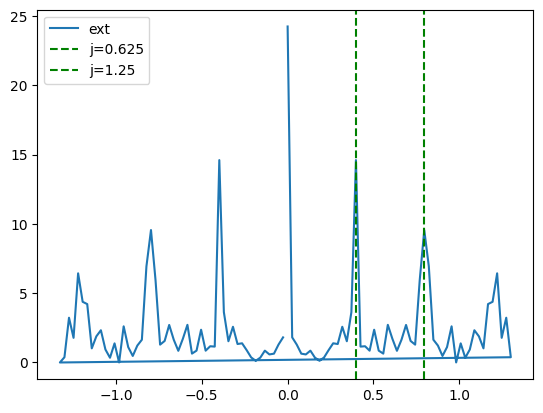

In [41]:
from scipy.signal import find_peaks

k = 4

extended = ramseyBatch1.get_zi(k)[::-1]
extended = extended + ramseyBatch1.get_zi(k)
fft_output_ext = np.fft.fft(extended)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def extract_two_closest_to_zero(frequencies, peaks):
    """Extract the two peaks closest to zero from the given peaks."""
    # Sort peaks based on their absolute distance to zero
    sorted_peaks = sorted(peaks, key=lambda x: abs(frequencies[x]))
    return sorted_peaks[:2]


# Set the sampling rate based on measurements
sample_rate = measurements / (6 * np.pi)

# Compute the positive frequencies for the FFT output
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(k)), 1 / sample_rate)
positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

# Find peaks in the positive magnitudes
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
n_highest_peaks = sorted_peak_indices[:3]

# Extract two peaks closest to zero
selected_peaks = extract_two_closest_to_zero(frequencies_ext[positive_indices], n_highest_peaks)

# Plot and annotate results
plt.plot(frequencies_ext, np.abs(fft_output_ext), label="ext")

for peak_index in selected_peaks:
    freq_value = frequencies_ext[positive_indices][peaks[peak_index]]
    magnitude_value = peak_magnitudes[peak_index]

    print(f"Frequency: {freq_value * (0.5 * np.pi)}, Magnitude: {magnitude_value}")
    plt.axvline(x=freq_value, color='green', linestyle='--', label=f'j={freq_value * 0.5 * np.pi}')

#plt.xlim(0,2)
# Show the plot
plt.legend()
plt.show()

## Two qubit FFT ##

Frequency: 1.25, Magnitude: 15.921009335001553


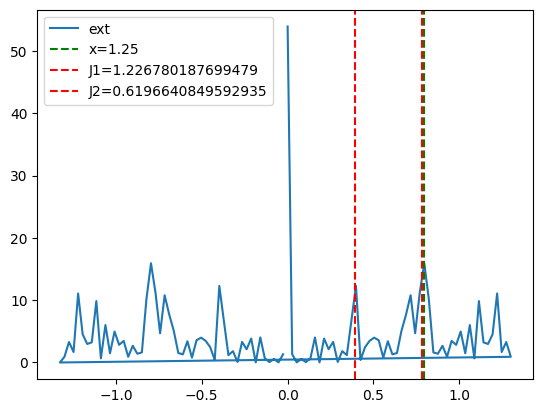

In [54]:
from scipy.signal import find_peaks

k = 3
j = 4

extended1 = ramseyBatch1.get_zi(k)[::-1]
extended1 = extended1 + ramseyBatch1.get_zi(k)

extended2 = ramseyBatch1.get_zi(j)[::-1]
extended2 = extended2 + ramseyBatch1.get_zi(j)

extended = [a + b for a, b in zip(extended1, extended2)]

fft_output_ext = np.fft.fft(extended)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def extract_two_closest_to_zero(frequencies, peaks):
    """Extract the two peaks closest to zero from the given peaks."""
    # Sort peaks based on their absolute distance to zero
    sorted_peaks = sorted(peaks, key=lambda x: abs(frequencies[x]))
    return sorted_peaks[:2]


# Set the sampling rate based on measurements
sample_rate = measurements / (6 * np.pi)

# Compute the positive frequencies for the FFT output
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(k)), 1 / sample_rate)
positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

# Find peaks in the positive magnitudes
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
n_highest_peaks = sorted_peak_indices[:1]

# Extract two peaks closest to zero
selected_peaks = extract_two_closest_to_zero(frequencies_ext[positive_indices], n_highest_peaks)

# Plot and annotate results
plt.plot(frequencies_ext, np.abs(fft_output_ext), label="ext")

for peak_index in selected_peaks:
    freq_value = frequencies_ext[positive_indices][peaks[peak_index]]
    magnitude_value = peak_magnitudes[peak_index]

    print(f"Frequency: {freq_value * (0.5 * np.pi)}, Magnitude: {magnitude_value}")
    plt.axvline(x=freq_value, color='green', linestyle='--', label=f'x={freq_value * 0.5 * np.pi}')

plt.axvline(x=J[k] / (0.5 * np.pi), color='red', linestyle='--', label=f'J1={J[k]}')
plt.axvline(x=J[j] / (0.5 * np.pi), color='red', linestyle='--', label=f'J2={J[j]}')

#plt.xlim(0,3)
# Show the plot
plt.legend()
plt.show()

In [12]:
def extract_two_closest_to_zero(frequencies, peaks):
    """Extract the two peaks closest to zero from the given peaks."""
    # Sort peaks based on their absolute distance to zero
    sorted_peaks = sorted(peaks, key=lambda x: abs(frequencies[x]))
    return sorted_peaks[:2]


sample_rate = measurements / (10 * np.pi)

peak_pairs = []
for i in range(n):
    extended = ramseyBatch1.get_zi(i)[::-1]
    extended = extended + ramseyBatch1.get_zi(i)
    fft_output_ext = np.fft.fft(extended)
    frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(i)), 1 / sample_rate)

    positive_indices = np.where(frequencies_ext > 0)
    positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

    # Find peaks in the positive magnitudes
    peaks, _ = find_peaks(positive_magnitudes)

    # Get the magnitudes of these peaks
    peak_magnitudes = positive_magnitudes[peaks]

    # Sort the peaks by their magnitudes in descending order
    sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
    n_highest_peaks = sorted_peak_indices[:3]

    # Extract two peaks closest to zero
    selected_peaks = extract_two_closest_to_zero(frequencies_ext[positive_indices], n_highest_peaks)

    freq = []
    for peak_index in selected_peaks:
        freq.append(frequencies_ext[positive_indices][peaks[peak_index]] * (0.5 * np.pi))

    peak_pairs.append((freq[0], freq[1]))
print(peak_pairs)


def find_ordered_js(peak_pairs):
    ordered_js = []
    n = len(peak_pairs)

    # Start with the first qubit
    current_peaks = list(peak_pairs[0])

    for i in range(n):
        next_peaks = peak_pairs[(i + 1) % n]

        # Find the closest peak between the two sets
        distances = (
        min([abs(current_peaks[0] - p) for p in next_peaks]), min([abs(current_peaks[1] - p) for p in next_peaks]))

        if (distances[0] < distances[1]):
            ordered_js.append(current_peaks[0])
        else:
            ordered_js.append(current_peaks[1])

        current_peaks = next_peaks

    return ordered_js


ordered_js = find_ordered_js(peak_pairs)
print(ordered_js)
#[1.2994418279088895, 0.7049372527771903, 0.8584715400487917, 1.170570573845352]


[(1.175, 1.2999999999999998), (0.7, 1.2999999999999998), (0.7, 0.85), (0.85, 1.175)]
[1.2999999999999998, 0.7, 0.85, 1.175]


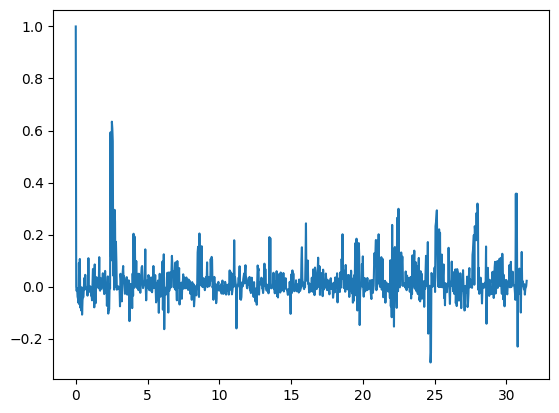

In [6]:
plt.plot(delay, ramseyBatch1.get_zi(0), label='Simulation')

## Large number of qubits ##

In [65]:
from scipy.optimize import curve_fit
import random
import importlib
import ramsey_experiment
from tqdm.notebook import tqdm

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 1000

shots = 5
J = [random.gauss(100, 5) for _ in range(n)]
manual_run = []
measurements = 400
delay = np.linspace(0, 0.5 * np.pi, measurements)
for t in tqdm(delay, desc='Running experiments'):
    manual_run.append(RamseyExperiment(n, t, shots, J, "0", manual=True))
ramseyBatch1 = RamseyBatch(manual_run)
ramseyBatch2 = RamseyBatch(manual_run)

ramseyBatch1.no_fit_double(use_fft=True)
ramseyBatch2.no_fit(use_fft=True)

J_fit1 = ramseyBatch1.J_fit
J_fit2 = ramseyBatch2.J_fit

print("dist1 :" + str(ramseyBatch1.dist))
print("dist2 :" + str(ramseyBatch2.dist))


ibmqfactory.load_account:WARNING:2023-12-14 16:00:39,915: Credentials are already in use. The existing account in the session will be replaced.


Running experiments:   0%|          | 0/400 [00:00<?, ?it/s]

dist1 :9.610191056334378
dist2 :4.389786910854778


In [66]:
dist_vec1 = [np.abs(J[i] - J_fit1[i]) for i in range(n)]
dist_vec2 = [np.abs(J[i] - J_fit2[i]) for i in range(n)]

error_rate1 = sum([1 if dist_vec1[i] > 5 else 0 for i in range(n)]) / n
error_rate2 = sum([1 if dist_vec2[i] > 5 else 0 for i in range(n)]) / n

print(error_rate1)
print(error_rate2)

#print(dist_vec)

0.024
0.035
